In [ ]:
# NOTE figure out if this is still needed because 
# it's also in Step_0 of the calibration section (and probably shouldn't be)

# Post Map Match
- Get map match results
- Aggregate matches to links
- Get chosen route characterstics
- Export for impedance calibration

In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import pickle
import sys
from collections import Counter

from bikewaysim.paths import config
from bikewaysim.map_matching import post_process

# combines the map match results into a single file
post_process.combine_results()

0


In [2]:
# load network
links = gpd.read_file(config['network_fp']/'final_network.gpkg',layer='edges')
nodes = gpd.read_file(config['network_fp']/'final_network.gpkg',layer='nodes')

# load the trips
with (config['cycleatl_fp']/'trips_4.pkl').open('rb') as fh:
    trips_df = pickle.load(fh)

# load the matches
# NOTE use this to indicate which match results to load
match_settings_idx = 0
with (config['matching_fp'] / f"match_dict_full_{match_settings_idx}.pkl").open('rb') as fh:
    match_dict = pickle.load(fh)

In [6]:
# NOTE determine the cutoff to use for an acceptable match
cutoff = 0.90 # set pct of points that need to be matched
above_threshold, below_threshold, failed_matches, match_ratios = post_process.mapmatch_results(match_dict,cutoff)
match_dict = {key:item for key,item in match_dict.items() if key in above_threshold}

# the linkid and direction of the matched edges
matched_edges_dict = {tripid:[(int(x),bool(y)) for x,y in item['edges'].values] for tripid, item in match_dict.items()}
# the lines that connect the GPS points to the network nodes
match_lines = {tripid:int(item['match_lines']['length'].mean()) for tripid, item in match_dict.items()}
# the pct of points that were matched
match_ratios = {tripid:round(item['match_ratio'],1) for tripid, item in match_dict.items()}

# add match dist and ration to the trips dataframe
trips_df['match_dist'] = trips_df['tripid'].map(match_lines)
trips_df['match_ratio'] = trips_df['tripid'].map(match_ratios)

597 / 597 (100%) successful matches
0 / 597 (0%) partial matches
0 / 597 (0%) failed matches


array([[<Axes: title={'center': 'match_dist'}>]], dtype=object)

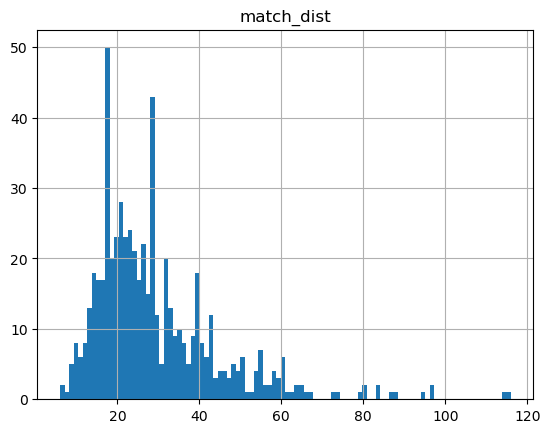

In [7]:
# plot the match distances
trips_df.hist('match_dist',bins=100)

# Aggregate matches to links

In [ ]:
from collections import Counter, defaultdict
import pandas as pd
#feed in a subset of matched_edges to return counts for specific queries such as
#the gender split on a link etc

links_fwd = defaultdict(list)
links_rev= defaultdict(list)
links_undirected = defaultdict(list)
for tripid, link_list in matched_edges_dict.items():
    for linkid in link_list:
        linkid0 = int(linkid[0])
        linkid1 = linkid[1]
        links_undirected[linkid[0]].append(tripid)
        if linkid1 == False:
            links_fwd[linkid0].append(tripid)
        else:
            links_rev[linkid0].append(tripid)

links_fwd = pd.Series(links_fwd)
links_rev = pd.Series(links_rev)
links_undirected = pd.Series(links_undirected)

link_counts = pd.DataFrame({'fwd':links_fwd,'rev':links_rev,'both':links_undirected})
link_counts['total_fwd'] = link_counts['fwd'].apply(lambda x: len(x) if isinstance(x,list) else 0)
link_counts['total_rev'] = link_counts['rev'].apply(lambda x: len(x) if isinstance(x,list) else 0)
link_counts['total'] = link_counts['both'].apply(lambda x: len(x) if isinstance(x,list) else 0)

#turn index back to int
link_counts.index = link_counts.index.astype(int)
#name the index
link_counts.index.name = 'linkid'

In [ ]:
users = pd.read_pickle(config['cycleatl_fp']/'users_4.pkl')
trips = pd.read_pickle(config['cycleatl_fp']/'trips_4.pkl')
trips0 = pd.read_pickle(config['cycleatl_fp']/'trips_2.pkl')
userid = trips['userid'].to_dict()
users.set_index('userid',inplace=True)

In [ ]:
import numpy as np
link_counts['fwd_users'] = link_counts['fwd'].apply(lambda x: list(set([userid[y] for y in x])) if isinstance(x,list) else np.nan)
link_counts['rev_users'] = link_counts['rev'].apply(lambda x: list(set([userid[y] for y in x])) if isinstance(x,list) else np.nan)
link_counts['both_users'] = link_counts['both'].apply(lambda x: list(set([userid[y] for y in x])) if isinstance(x,list) else np.nan)

link_counts['total_fwd_users'] = link_counts['fwd_users'].apply(lambda x: len(x) if isinstance(x,list) else 0)
link_counts['total_rev_users'] = link_counts['rev_users'].apply(lambda x: len(x) if isinstance(x,list) else 0)
link_counts['total_users'] = link_counts['both_users'].apply(lambda x: len(x) if isinstance(x,list) else 0)

In [ ]:
trips0.set_index('tripid',inplace=True)
test = trips0['start_time'].dt.year.to_dict()
years = pd.DataFrame.from_dict(link_counts['both'].dropna().apply(lambda x: Counter([test.get(y) for y in x])).to_dict(),orient='index')
years.columns = [str(x) for x in years.columns]

In [ ]:
years.index.name = 'tripid'
years = years.fillna(0).astype(int)
link_counts = link_counts.merge(years,left_index=True,right_index=True,how='left')
link_counts.fillna(0,inplace=True)

In [ ]:
# TODO script this to get the attributes we generally want
# at some point look at more specific trip characterstics like average speed

# Trip attributes
commute = set(trips.loc[trips.trip_type == 'Commute'].index.tolist())
link_counts['commute_trips'] = link_counts['both'].apply(lambda x: len([y for y in x if y in commute]) if isinstance(x,list) else 0)

# User attributes
female = set(users.loc[users['gender']=='Female'].index.tolist())
male = set(users.loc[users['gender']=='Male'].index.tolist())
link_counts['female_trips'] = link_counts['both_users'].apply(lambda x: len([y for y in x if y in female]) if isinstance(x,list) else 0)
link_counts['male_trips'] = link_counts['both_users'].apply(lambda x: len([y for y in x if y in male]) if isinstance(x,list) else 0)


In [ ]:
link_counts['2014']

In [ ]:
new_links = pd.merge(links,link_counts,left_on='linkid',right_index=True)

new_links.fillna(0,inplace=True)

for col in ['fwd','rev','both','fwd_users','rev_users','both_users']:
    new_links[col] = new_links[col].astype(str)
new_links.to_file(Path.home()/'Downloads/link_counts.gpkg')

# I think ignore everthing past here

# Route attributes for each trip


In [ ]:
links = gpd.read_file(config['network_fp']/'final_network.gpkg',layer='edges')
links.set_index('linkid',inplace=True)
directed_links = pd.read_parquet(config['network_fp']/'directed_edges.parquet')
directed_links.set_index(['linkid','reverse_link'],inplace=True)

df2 = directed_links[['ascent_grade_cat', 'ascent_ft', 'ascent_grade_cat', 'descent_grade_cat',
       'descent_ft']]
directed_links.fillna(df2,inplace=True)

In [ ]:
directed_links.columns

In [ ]:
# how high?
ascent_ft = directed_links['ascent_ft'].to_dict()
# climb = {key:directed_links.loc[item,'ascent_ft'].sum() for key,item in matched_edges_dict.items()}
climb = {key:np.sum([ascent_ft.get(x) for x in item]) for key,item in matched_edges_dict.items()}
pd.Series(climb)
# directed_links.loc[matched_edges_dict[71],'ascent_ft'].sum()

In [ ]:
# how long
length_dict = links.length
length = {key:np.sum([length_dict.get(x[0]) for x in item]) for key,item in matched_edges_dict.items()}
# length = (pd.Series(length) / 5280).round(1)

In [ ]:
directed_links['facility_fwd'].unique()

In [ ]:
set(directed_links.loc[directed_links['facility_fwd']==bike_infras].index.tolist())

In [ ]:
bike_infras = ['multi use path','bike lane','buffered bike lane','cycletrack']
bike_results = []

for bike_infra in bike_infras:
    # how pct of route on bike lanes
    bike_lanes = set(directed_links.loc[directed_links['facility_fwd']==bike_infra].index.tolist())
    bike_lanes = {key: np.round(np.sum([length_dict.get(x[0]) for x in item if x in bike_lanes]) / length.get(key) * 100,0) for key,item in matched_edges_dict.items()}
    bike_lanes = pd.Series(bike_lanes)
    bike_lanes.name = bike_infra
    bike_results.append(pd.Series(bike_lanes))
bike_infra = pd.concat(bike_results,axis=1)

In [ ]:
links = links['link_type']=='road'

In [ ]:
bike_lanes

In [ ]:
directed_links['facility_fwd'].unique()

In [ ]:
matched_edges_dict[513]

In [ ]:
len(matched_edges_dict[71])


In [ ]:
(int(36689),bool(False))

In [ ]:
# new_links.sort_values('total_users',ascending=False).head(400).explore()

In [ ]:
link_counts.index

In [ ]:
pd.Series(links_fwd)

In [ ]:
linkid[0]

In [ ]:
big_flat_list = [item for sublist in list_of_lists for item in sublist]

In [ ]:
import itertools


def aggregate_trips_to_links(links,matched_traces,tripids,name):
    
    
    
    if tripids is not None:
        #use list of tripids to subset dict of matched traces
        filtered_dict = {key:item for key,item in matched_traces.items() if key in set(tripids)}
    else:
        filtered_dict = matched_traces
    #make one large series
    list_of_links = [item['edges'] for key, item in filtered_dict.items()]
    list_of_links = list(itertools.chain(*list_of_links))
    series_of_links = pd.Series(list_of_links)
    links[name] = links['linkid'].map(series_of_links.value_counts())
    return links

In [ ]:
import itertools
def aggregate_trips_to_link(link_dict,matched_traces,tripids,name):
    
    
    
    if tripids is not None:
        #use list of tripids to subset dict of matched traces
        filtered_dict = {key:item for key,item in matched_traces.items() if key in set(tripids)}
    else:
        filtered_dict = matched_traces
    #make one large series
    list_of_links = [item['edges'] for key, item in filtered_dict.items()]
    list_of_links = list(itertools.chain(*list_of_links))
    series_of_links = pd.Series(list_of_links)
    links[name] = links['linkid'].map(series_of_links.value_counts())
    return links

In [ ]:

directed_links = pd.read_parquet(config['network_fp']/'directed_edges.parquet')

aggregated_undirected_matched = { key : [] for key in directed_links['linkid'].tolist()}
aggregated_directed_matched = { key : [] for key in list(zip(directed_links['linkid'],directed_links['reverse_link']))}

In [ ]:

# links = gpd.read_file(config['network_fp']/'final_network.gpkg',layer='edges')

#add basic count
#links.set_index('linkid',inplace=True)
links['trips'] = links['linkid'].apply(lambda x: len(aggregated_undirected_matched.get(x,[])))
links['trips'].describe()
only_trips = links[links['trips']>0]
only_trips.to_file(config['calibration_fp']/'scratch.gpkg',layer='link_counts')

## Aggregate tripids and userids to links

## Aggregate route characterstics for each trip
Think intentionally about what we include here
- Length
- Elevation (compare this to RWGPS)
- Grade with different grade splits
- Bike lane, cycletrack, bike path (PATH/BeltLine), pedestrian
- Road heirarchy/classification
- Speed
- Lanes (1,2,3 and remove 1 where car=no)
- AADT with a 10,000 AADT cutoff
- Motor vehicles allowed
- Adjacent to road network

In [ ]:
10 * 3000 / 60 / 60